#### Yoav Henig Project - building a CNN
##### Thank you very much

### Setup
tf2onnx - python library to convert tensorflow models to ONNX format

In [1]:
!pip install tf2onnx onnx-simplifier

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |################################| 398 kB 43.6 MB/s eta 0:00:01
     |################################| 12.3 MB 60.5 MB/s eta 0:00:01
     |################################| 466 kB 61.7 MB/s eta 0:00:01
     |################################| 4.5 MB 67.0 MB/s eta 0:00:01
  Created wheel for onnx-simplifier: filename=onnx_simplifier-0.3.6-py3-none-any.whl size=12860 sha256=a88d653594851af8b250f4286b529acdc25e6eac818b7c0d5d750001a4fa0986
  Stored in directory: /home/ubuntu/.cache/pip/wheels/93/c9/63/2921c8cfd01f9bc94c910e81597166eda75709ee5003fc9597
Successfully built onnx-simplifier
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


### Model Creation
Fisrt we import the dataset and preprocess it

In [9]:
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.datasets import fashion_mnist

def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    return trainX, trainY, testX, testY


X_train, y_train, X_test, y_test = load_dataset()

def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm


X_train, X_test = prep_pixels(X_train, X_test)
print("Done converting to float32 normalized values")

Done converting to float32 normalized values


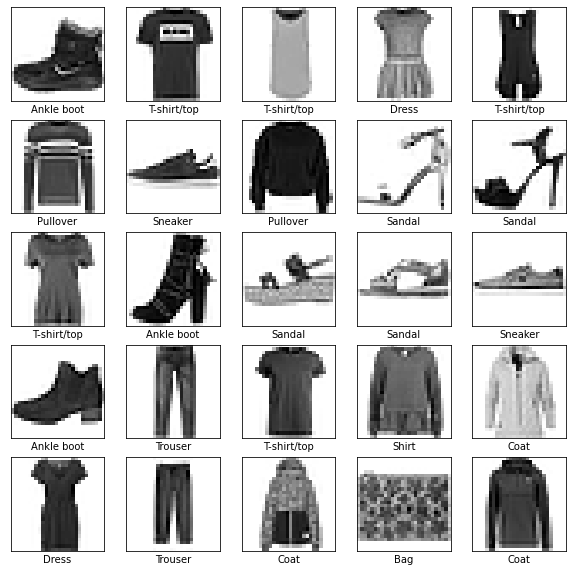

In [10]:
from matplotlib import pyplot as plt

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# plot first few images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
# show the figure
plt.show()

In [12]:
# one hot encode target values
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [20]:
num_classes = len(class_names)
item_names = dict(enumerate(class_names))
item_names

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

Define the model and train

In [28]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 131us/sample - loss: 0.4128 - accuracy: 0.8536
Epoch 2/10
60000/60000 [==============================] - 7s 122us/sample - loss: 0.2753 - accuracy: 0.8984
Epoch 3/10
60000/60000 [==============================] - 8s 130us/sample - loss: 0.2370 - accuracy: 0.9136
Epoch 4/10
60000/60000 [==============================] - 7s 122us/sample - loss: 0.2078 - accuracy: 0.9242
Epoch 5/10
60000/60000 [==============================] - 7s 121us/sample - loss: 0.1876 - accuracy: 0.9306
Epoch 6/10
60000/60000 [==============================] - 7s 121us/sample - loss: 0.1671 - accuracy: 0.9380
Epoch 7/10
60000/60000 [==============================] - 7s 122us/sample - loss: 0.1509 - accuracy: 0.9441
Epoch 8/10
60000/60000 [==============================] - 7s 122us/sample - loss: 0.1365 - accuracy: 0.9497
Epoch 9/10
60000/60000 [==============================] - 7s 121us/sample - loss: 0.1210 - accuracy: 0.9557
Epoch

In [29]:
# evaluate model
_, acc = model.evaluate(X_test, y_test, verbose=0)

Acc: 91.080%


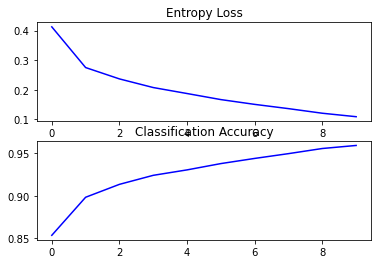

In [30]:
print(f'Acc: {(acc * 100.0):.3f}%')
print("="*35)
# plot loss
plt.subplot(211)
plt.title('Entropy Loss')
plt.plot(history.history['loss'], color='b', label='train')
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='b', label='train')

plt.show()

Since in evaluate function we got 91.080% (and in train 95.9%) it seems a little bit overfitting

### Convert to ONNX
To convert to ONNX format file we use tf2onnx python lib, it parses to model api from tensorflow and encode the data into ONNX format

In [31]:
import tf2onnx

path = "/tmp/model.onnx"

input_signature = [tf.TensorSpec([1, 28, 28, 1], tf.float32, name='x')]
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=13)
with open(path, "wb") as f:
    f.write(onnx_model.SerializeToString())

print(f"Saved onnx model to {path}")

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
Saved onnx model to /tmp/model.onnx


### Build a different model with W&B monitoring

In [32]:
# WandB – Install the W&B library
#!pip install wandb -q
#!pip install opencv-python
import wandb
from wandb.keras import WandbCallback

You should consider upgrading via the '/home/ubuntu/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [33]:
# Initilize a new wandb run
wandb.init(entity="yhenig", project="project")

# Default values for hyper-parameters
config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs
config.learning_rate = 0.01
config.epochs = 35
config.img_width=28
config.img_height=28
config.num_classes = num_classes
config.batch_size = 128
config.validation_size = 5000
config.weight_decay = 0.0005
config.activation = 'relu'
config.optimizer = 'nadam'
config.seed = 42

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/ubuntu/.netrc


Now lets try a different model (Adam optimizer)

In [35]:
#define CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# define the optimizer
optimizer = tf.keras.optimizers.Adam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
# compile model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Augment the data for more examples

In [36]:
# Data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_train)

In [37]:
%%wandb
# fit model
history = model.fit(X_train, y_train,
                    epochs=config.epochs, batch_size=config.batch_size,
                    validation_data=(X_test, y_test),
                    verbose=0,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                              WandbCallback(data_type="image", validation_data=(X_test, y_test), labels=item_names)])
# evaluate model
_, acc = model.evaluate(X_test, y_test, verbose=0)

Acc: 90.250%


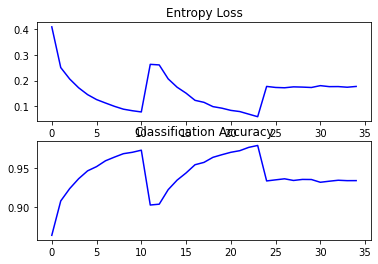

In [38]:
print(f'Acc: {(acc * 100.0):.3f}%')
print("="*35)
# plot loss
plt.subplot(211)
plt.title('Entropy Loss')
plt.plot(history.history['loss'], color='b', label='train')
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='b', label='train')

plt.show()

It seems we should decrease the learning rate, lets build another model:

In [45]:
def benchmark(lr=0.0001, epochs=config.epochs):
    #define CNN model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    # define the optimizer
    optimizer = tf.keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    # compile model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Data augmentation
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # fit model
    history = model.fit(X_train, y_train,
                        epochs=config.epochs, batch_size=config.batch_size,
                        validation_data=(X_test, y_test),
                        verbose=0,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                                  WandbCallback(data_type="image", validation_data=(X_test, y_test), labels=item_names)])
    # evaluate model
    _, acc = model.evaluate(X_test, y_test, verbose=0)

    print(f'Acc: {(acc * 100.0):.3f}%')
    print("="*35)
    # plot loss
    plt.subplot(211)
    plt.title('Entropy Loss')
    plt.plot(history.history['loss'], color='b', label='train')
    plt.plot(history.history['val_loss'], color='r', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='b', label='train')
    plt.plot(history.history['val_accuracy'], color='r', label='test')

    plt.show()

Acc: 92.160%


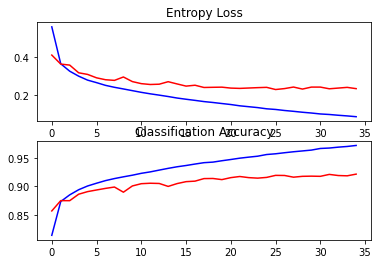

In [42]:
# lr=0.0001
benchmark(0.0001)

Still overfitting but accuracy much better now. Lets increase the lr a bit.

Acc: 92.320%


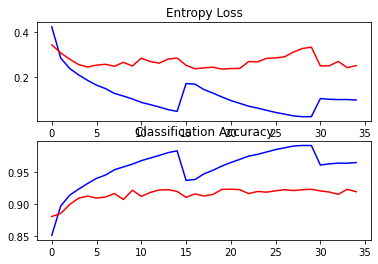

In [43]:
# lr=0.0005
benchmark(0.0005)

Even though we got unsteady loss and accuracy we do got better results.<br>
Lets try one last

Acc: 92.130%


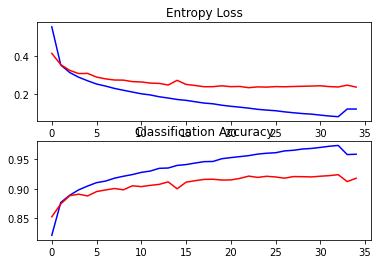

In [46]:
# lr=0.0001, epochs=50
benchmark(0.0001, 50)

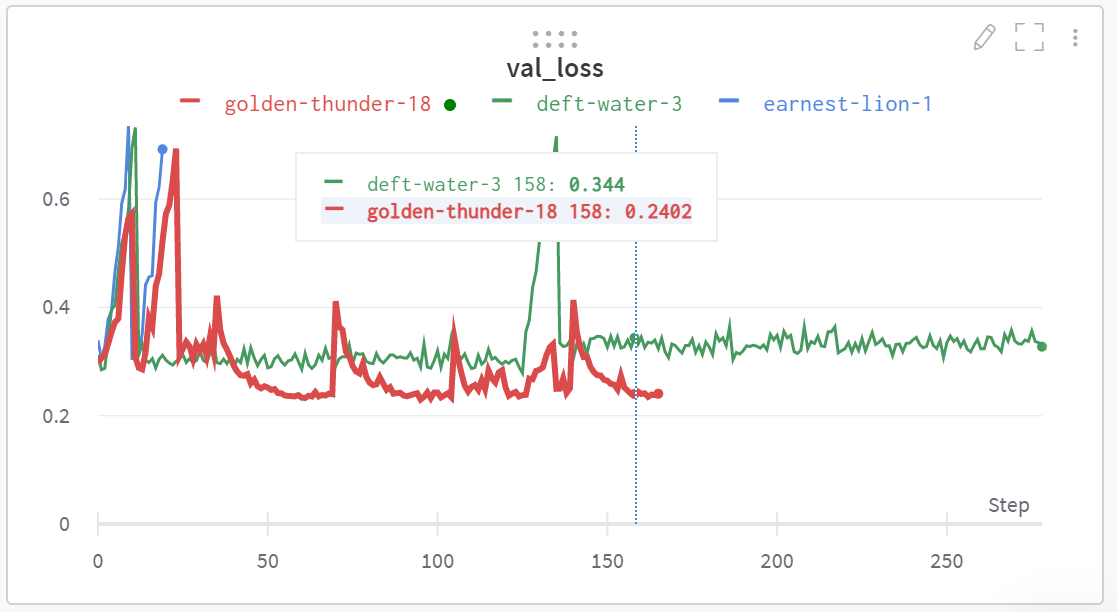

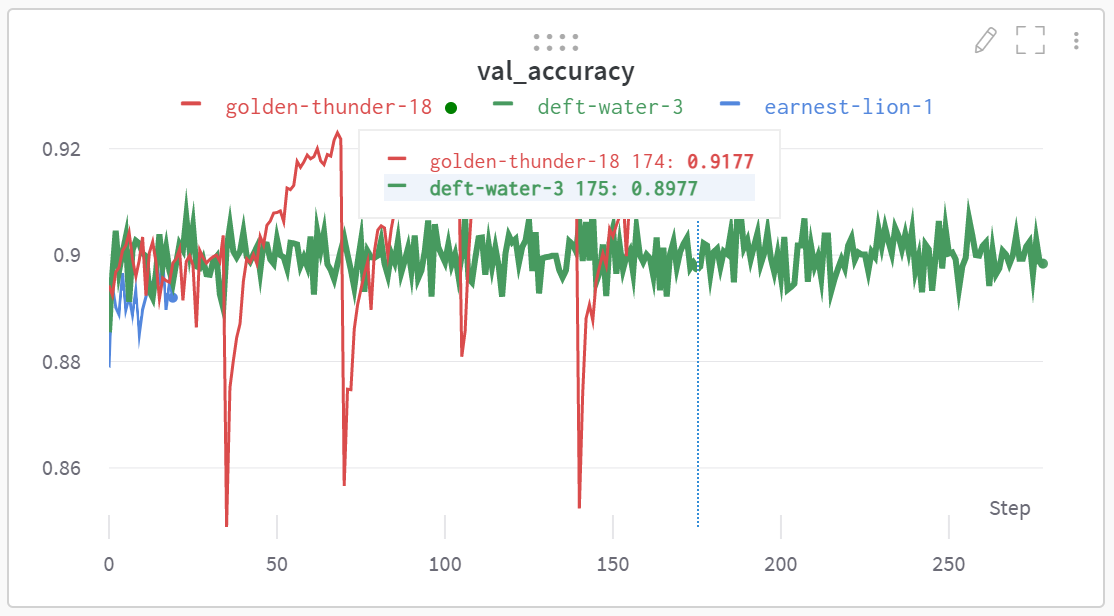

Still overfitting but accuracy much better now, lets save this model in '.h5' format

In [44]:
model.save('model1.h5')